In [98]:
from pathlib import Path

import xarray as xr
import numpy as np
from scipy import stats as ss
from matplotlib import pyplot as plt

### Define the data folder where the images and simulation data are stored

In [92]:
notebook_dir = Path.cwd()
DATA_FOLDER = notebook_dir / "data"

if not DATA_FOLDER.exists():
    raise ValueError("Data folder with results not found.")
    
IMG_FOLDER = notebook_dir / "img"
IMG_FOLDER.mkdir(parents=True, exist_ok=True)

In [158]:
TEX_RC_PARAMS = {
    'backend': 'ps',
    'text.latex.preamble': [r'\usepackage{gensymb}'],
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'font.family': 'serif'
}

### Define the parameters of the simulation data

In [93]:
DEVICE_TYPES = ["transmon", "mixed"]
DISTANCES = [3, 5, 7]
MIN_RES_VAR = 1e-3
MAX_RES_VAR = 1e-1

In [101]:
collision_arrs = []

for device_type in DEVICE_TYPES:
    device_results = []
    num_seeds = 10000 if device_type == "transmon" else 6000
    version = "v2_collision_7_disabled"  if device_type == "transmon" else "v3"
    for dist in DISTANCES:
        da_name = f"{device_type}_device_yield_d_{dist}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{num_seeds}_{version}.nc"
        arr = xr.load_dataarray(DATA_FOLDER/da_name)
        device_results.append(arr)
    
    merged_arr = xr.concat(device_results, dim="distance")
    merged_arr["device_type"] = device_type
    collision_arrs.append(merged_arr)

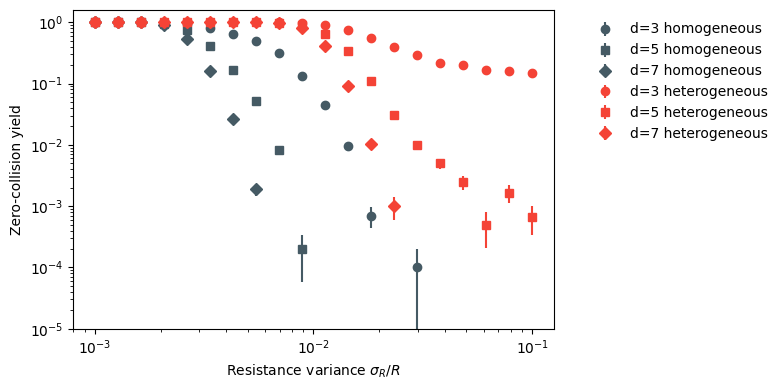

In [124]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

markers = ["o", "s", "D"]
colors = dict(transmon = "#455a64", mixed = "#f44336")


lines = []
for device_type, collision_arr in zip(DEVICE_TYPES, collision_arrs):
    color = colors[device_type]
    device_lines = []
    
    device_yield = collision_arr.mean(dim="seed")
    yield_stds = collision_arr.std(dim="seed")
    yield_sems = yield_stds/np.sqrt(collision_arr.seed.size)
    
    for dist_ind, distance in enumerate(distances):
        type_label = "homogeneous" if device_type == "transmon" else "heterogeneous"
        label = f"d={distance} {type_label}"
        marker = markers[dist_ind]
        
        line_plot = ax.errorbar(
            device_yield.resist_var, 
            device_yield.sel(distance=distance),
            yield_sems.sel(distance=distance),
            marker=marker,
            linestyle="",
            color=color,
            label=label,
            
        )
        device_lines.extend(line_plot)
    lines.append(device_lines)
    
ax.set_xscale("log")
ax.set_xlabel(r"Resistance variance $\sigma_{R}/R$")
ax.set_ylabel(r"Zero-collision yield")
ax.set_yscale("log")
ax.set_ylim(1e-5)
#ax.set_xlim(1e-3, 1e-1)


legend = plt.legend(
    ncol=1, 
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

fig.tight_layout()
plt.show()

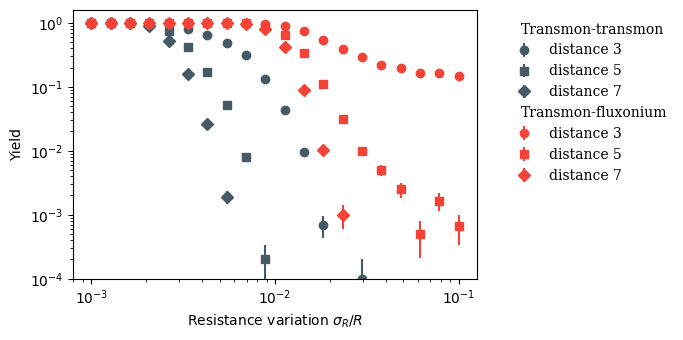

In [177]:
SAVE_IMAGE = True

fig, ax = plt.subplots(figsize=(7, 3.5), dpi=100)

markers = ["o", "s", "D"]
colors = dict(transmon = "#455a64", mixed = "#f44336")

lines = []
with plt.rc_context(TEX_RC_PARAMS):
    for device_type, collision_arr in zip(device_types, collision_arrs):
        color = colors[device_type]
        device_lines = []

        device_yield = collision_arr.mean(dim="seed")
        yield_stds = collision_arr.std(dim="seed")
        yield_sems = yield_stds/np.sqrt(collision_arr.seed.size)

        for dist_ind, distance in enumerate(distances):
            type_label = "transmon-transmon" if device_type == "transmon" else "transmon-fluxonium"
            label = f"d={distance} {type_label}"
            marker = markers[dist_ind]

            line_plot = ax.errorbar(
                device_yield.resist_var, 
                device_yield.sel(distance=distance),
                yield_sems.sel(distance=distance),
                marker=marker,
                linestyle="",
                color=color,
                label=label,

            )
            device_lines.append(line_plot)
        lines.append(device_lines)

    ax.set_xscale("log")
    ax.set_xlabel(r"Resistance variation $\sigma_{R}/R$")
    ax.set_ylabel(r"Yield")
    ax.set_yscale("log")
    ax.set_ylim(1e-4)

    labels = []
    for device_type in device_types:
        title_label = "Transmon-transmon" if device_type == "transmon" else "Transmon-fluxonium"
        labels.append(title_label)
        for distance in distances: 
            marker_label = f"distance {distance}"
            labels.append(marker_label)

    h, l = ax.get_legend_handles_labels()
    ph = [plt.plot([],marker="", ls="")[0]]*2
    handles = ph[:1] + lines[0] + ph[1:] + h[3:]

    legend = plt.legend(
        handles, 
        labels, 
        ncol=1, 
        frameon=False,
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    for vpack in legend._legend_handle_box.get_children():
        for hpack in vpack.get_children()[:1]:
            hpack.get_children()[0].set_width(0)
        for hpack in vpack.get_children()[4:5]:
            hpack.get_children()[0].set_width(0)

    fig.tight_layout()
    
if SAVE_IMAGE: 
    image_name = f"device_yields_comparison"
    for file_format in ['pdf', 'png']:
        full_name = f"{image_name}.{file_format}"
        plt.savefig(
            IMG_FOLDER / full_name,  
            dpi=300,  
            bbox_inches='tight', 
            transparent=True, 
            format=file_format
        )
plt.show()